<a href="https://colab.research.google.com/github/rajanaids-hub/Reinforcement_Learning_Lab/blob/main/Dyna_Q_Architecture_Exp10_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome to the Dyna-Q Experiment!
🚀 Training Q-Learning (0 Planning Steps)...
🚀 Training Dyna-Q (50 Planning Steps)...
✅ Experiment complete! Generating performance graph...


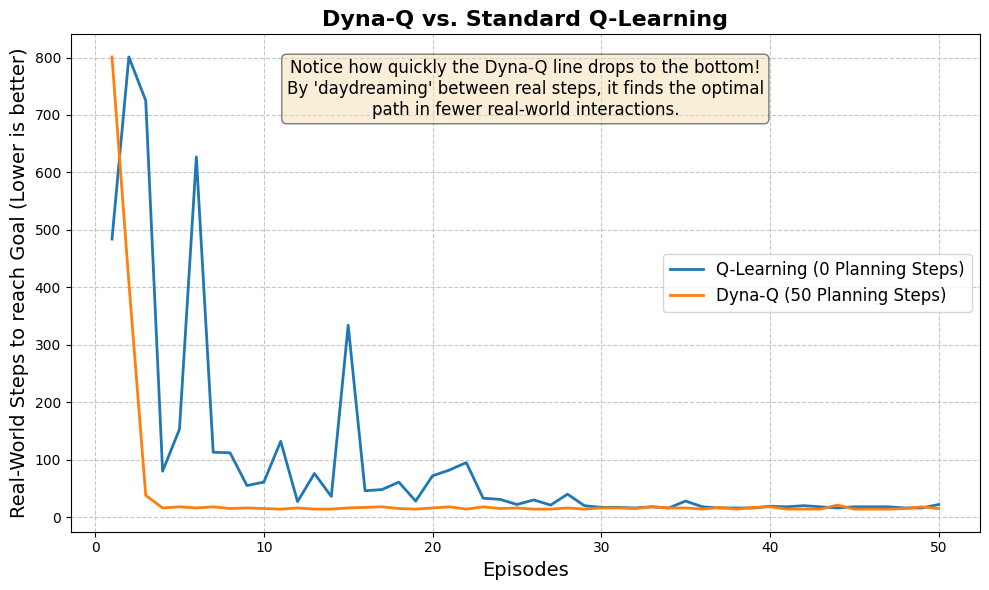

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

# =====================================================================
# 🎓 STUDENT EXPERIMENT SETTINGS: DYNA-Q 🎓
# =====================================================================
EPISODES = 50           # Number of episodes to train
ALPHA = 0.1             # Learning Rate
GAMMA = 0.95            # Discount Factor
EPSILON = 0.1           # Exploration Rate

# The magic number! How many "daydreams" (planning steps) the Dyna-Q
# agent does between every single real-world step.
PLANNING_STEPS = 50
# =====================================================================

# 1. The Environment: Classic Sutton & Barto Dyna Maze
class DynaMaze:
    def __init__(self):
        self.rows = 6
        self.cols = 9
        self.start_pos = (2, 0)
        self.goal_pos = (0, 8)

        # Obstacles the agent cannot walk through
        self.walls = [(1, 2), (2, 2), (3, 2), (4, 5), (0, 7), (1, 7), (2, 7)]
        self.state = self.start_pos

    def reset(self):
        self.state = self.start_pos
        return self.state

    def step(self, action):
        """0: UP, 1: RIGHT, 2: DOWN, 3: LEFT"""
        r, c = self.state

        if action == 0:   next_r, next_c = r - 1, c
        elif action == 1: next_r, next_c = r, c + 1
        elif action == 2: next_r, next_c = r + 1, c
        elif action == 3: next_r, next_c = r, c - 1

        # Check boundaries and walls
        if (next_r < 0 or next_r >= self.rows or
            next_c < 0 or next_c >= self.cols or
            (next_r, next_c) in self.walls):
            # Hit a wall, bounce back to the same state
            next_r, next_c = r, c

        self.state = (next_r, next_c)

        # Reward Structure: 0 for every step, +1 for reaching the goal
        if self.state == self.goal_pos:
            return self.state, 1.0, True
        else:
            return self.state, 0.0, False

# 2. The Agent: Capable of both standard Q-Learning and Dyna-Q
class DynaQAgent:
    def __init__(self, planning_steps=0):
        self.planning_steps = planning_steps

        # Q-Table: Dictionary mapping state -> array of 4 action values
        self.q_table = {}

        # The internal "Model" of the world for daydreaming.
        # Maps (state, action) -> (next_state, reward)
        self.model = {}

        # Keep track of states we've seen and actions we've taken in them
        # so we know what to daydream about.
        self.visited_states = []
        self.actions_taken = {}

    def get_q(self, state):
        """Helper to get Q-values, initializing missing states to zero."""
        if state not in self.q_table:
            self.q_table[state] = np.zeros(4)
        return self.q_table[state]

    def choose_action(self, state):
        if random.random() < EPSILON:
            return random.randint(0, 3) # Explore
        else:
            # Exploit (Break ties randomly to prevent getting stuck)
            q_values = self.get_q(state)
            max_q = np.max(q_values)
            return random.choice(np.where(q_values == max_q)[0])

    def update_q(self, state, action, reward, next_state):
        """Standard Q-Learning Update Formula"""
        current_q = self.get_q(state)[action]
        max_future_q = np.max(self.get_q(next_state))

        new_q = current_q + ALPHA * (reward + GAMMA * max_future_q - current_q)
        self.q_table[state][action] = new_q

    def learn(self, state, action, reward, next_state):
        # --- PHASE 1: DIRECT LEARNING ---
        # Update the Q-Table based on the real step we just took
        self.update_q(state, action, reward, next_state)

        # --- PHASE 2: MODEL BUILDING ---
        # Record what just happened into our mental model
        if state not in self.visited_states:
            self.visited_states.append(state)
            self.actions_taken[state] = []
        if action not in self.actions_taken[state]:
            self.actions_taken[state].append(action)

        self.model[(state, action)] = (next_state, reward)

        # --- PHASE 3: PLANNING (DAYDREAMING) ---
        # This is what makes Dyna-Q special! We simulate N fake steps using our memory.
        for _ in range(self.planning_steps):
            # 1. Randomly pick a state we have visited before
            sim_state = random.choice(self.visited_states)

            # 2. Randomly pick an action we have previously tried in that state
            sim_action = random.choice(self.actions_taken[sim_state])

            # 3. Ask our Model: "What happened when I did that?"
            sim_next_state, sim_reward = self.model[(sim_state, sim_action)]

            # 4. Train the Q-Table on this simulated experience!
            self.update_q(sim_state, sim_action, sim_reward, sim_next_state)

# 3. Experiment Runner
def run_experiment():
    env = DynaMaze()

    # We will race two agents to see who learns the fastest
    agents = {
        "Q-Learning (0 Planning Steps)": DynaQAgent(planning_steps=0),
        f"Dyna-Q ({PLANNING_STEPS} Planning Steps)": DynaQAgent(planning_steps=PLANNING_STEPS)
    }

    # We will record how many steps it takes each agent to finish each episode
    results = {name: [] for name in agents.keys()}

    for name, agent in agents.items():
        print(f"🚀 Training {name}...")

        for episode in range(EPISODES):
            state = env.reset()
            steps = 0
            done = False

            while not done:
                action = agent.choose_action(state)
                next_state, reward, done = env.step(action)

                # The agent learns from the real step (and plans if it's Dyna-Q!)
                agent.learn(state, action, reward, next_state)

                state = next_state
                steps += 1

                # Safety break in case it gets completely lost
                if steps > 800: break

            results[name].append(steps)

    return results

# 4. Visualization
def plot_results(results):
    fig, ax = plt.subplots(figsize=(10, 6))

    for name, steps_per_episode in results.items():
        # Plot the data
        ax.plot(range(1, EPISODES + 1), steps_per_episode, linewidth=2, label=name)

    ax.set_title("Dyna-Q vs. Standard Q-Learning", fontsize=16, weight='bold')
    ax.set_xlabel("Episodes", fontsize=14)
    ax.set_ylabel("Real-World Steps to reach Goal (Lower is better)", fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=12)

    # Add a note explaining the graph
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.5, 0.95,
            "Notice how quickly the Dyna-Q line drops to the bottom!\n"
            "By 'daydreaming' between real steps, it finds the optimal\n"
            "path in fewer real-world interactions.",
            transform=ax.transAxes, fontsize=12,
            verticalalignment='top', horizontalalignment='center', bbox=props)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    print("Welcome to the Dyna-Q Experiment!")
    results = run_experiment()
    print("✅ Experiment complete! Generating performance graph...")
    plot_results(results)